In [1]:
from Basics import *
setplot(dark=True)

import Measurements, SHMRs, HMFs, HODs, Profiles, SMFs, FFTs, ForwardModel

Start with a dictionary of cosmological parameters that are needed to construct all the components of the forward model. 

We'll also need some 

In [ ]:
bigdict = {
    'Data': {'name':'Liu2025', 'spefs': {'zbin':'1', 'dBeta':'1.2'}},
    'HMF': {'name':'hmf_package', 'spefs': {'mdef':'SOCritical', 'mfunc':'Tinker08'}},
    'HOD': {'name':'Kou2023', 'spefs': {'sample':'M*>10.8'}},
    'SMF': {'name': 'Gao2023', 'spefs': {'sample':'LRG', 'hemisphere':'south', 'zbin':'bin_1'}},
    'SHMR': {'name': 'Kravstov2014', 'spefs': {'sample': 'M200c'}},
    'onehalo': {'name':'Battaglia2012', 'spefs': {'model':'B12'}},
    'twohalo': {'name':'Amodeo2021', 'spefs': {'model':'GNFW'}},
}

cpars = {'hh': 0.7, 'Omega_L': 0.7, 'Omega_m': 0.3, 'Omega_b': 0.05, 'T_CMB': 2.726, 'XH':0.76}


In [81]:
datastudy = getattr(Measurements, bigdict['Data']['name'])(bigdict['Data']['spefs'])
datastudy.tSZdata_in_muK(cpars['T_CMB'])
thetas, meas, cov = datastudy.thetas, datastudy.tSZdata, datastudy.tSZcov
freq = datastudy.freq
dust = datastudy.dustprof
beam_ells, beam_data = datastudy.beam_ells, datastudy.beam_data
resp_ells, resp_data = datastudy.resp_ells, datastudy.resp_data

In [ ]:
cosmology = astropy.cosmology.LambdaCDM(H0=cpars["hh"]*100, Tcmb0=cpars['T_CMB'], Om0=cpars["Omega_m"], Ode0=cpars["Omega_L"], Ob0=cpars["Omega_b"])

H_func = lambda z: cosmology.H(z).to(u.km/u.s/u.Mpc).value
rhoc_func = lambda z: cosmology.critical_density(z).to(u.Msun/u.Mpc**3).value
dA_func = lambda z: cosmology.angular_diameter_distance(z).value
r200c_func = lambda m200c, z: (m200c/(4/3*np.pi*200*rhoc_func(z)))**(1/3)

In [60]:
SMF = getattr(SMFs, bigdict['SMF']['name'])(bigdict['SMF']['spefs'])
gdist = SMF.get_gdist(cpars, zweight=True)

mstars, zs = SMF.mstars, SMF.zs
mstars = mstars[np.sum(gdist, axis=1)/np.sum(gdist)>1e-3]

mhalos = getattr(SHMRs, bigdict['SHMR']['name'])(bigdict['SHMR']['spefs']).SHMR(mstars)


# Create a HMF function to use with the HOD
hmf = getattr(HMFs, bigdict['HMF']['name'])(bigdict['HMF']['spefs']).HMF(mhalos, zs, cpars)

# Define an HOD Model used for this method
HOD = getattr(HODs, bigdict['HOD']['name'])(bigdict['HOD']['spefs'])

/global/u2/c/cpopik/Capybara/SMFs.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.zdistscale = self.zdistdf.groupby('zbin')[f"{self.zbin}_{self.hemisphere}"].sum().values*self.surveyarea


In [ ]:
rs = np.logspace(-1, 1, 100)

# Define a profile
Pth1h = getattr(Profiles, bigdict['onehalo']['name'])(bigdict['onehalo']['spefs']).Pth1h(rs, mhalos, zs, rhoc_func, r200c_func, cpars)

Pth2h = getattr(Profiles, bigdict['twohalo']['name'])(bigdict['twohalo']['spefs']).Pth2h(rs, mhalos, zs)

Pth = lambda params={}: Pth1h(params)+Pth2h(params)

In [66]:
ave_HOD = ForwardModel.HODweighting(mhalos, zs, rs, HOD, hmf, r200c_func, H_func)

proj = ForwardModel.project_Hankel(rs, thetas, dA_func(SMF.zave), beam_data, beam_ells, resp_data, resp_ells)

sign = ForwardModel.Pth_to_muK(freq=freq, **cpars)


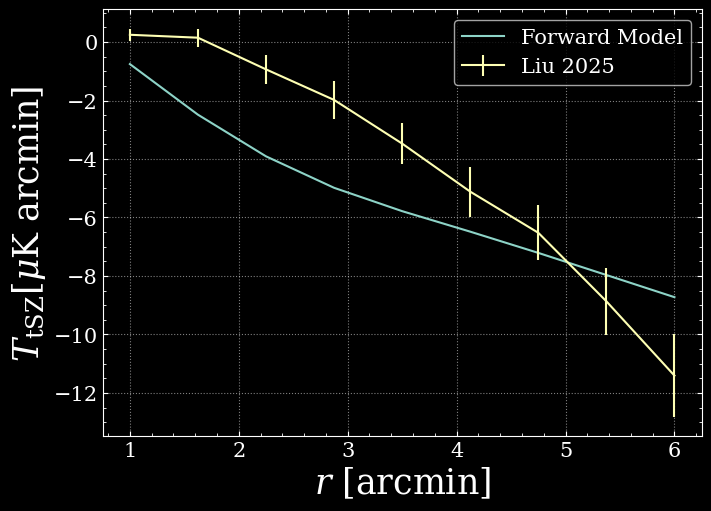

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), layout='constrained')
ax.set(xlabel=r'$r$ [arcmin]', ylabel=r'$T_\text{tSZ} [\mu \text{K arcmin}]$')

ax.plot(thetas, sign(proj(ave_HOD(Pth(), cpars))), label='Forward Model')
ax.errorbar(thetas, meas, np.diag(cov)**0.5, label='Liu 2025')

ax.legend(); plt.show()